In [3]:
import datetime
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import tables
from tqdm import tqdm
%matplotlib inline
import random

pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_hdf(r"C:\Users\ag-bahl\Desktop\sine_gratings_8_directions\data_vers_2_labeling.hdf5")
df.reset_index(inplace = True)
print('done all data')

done all data


In [ ]:
# split the data into optimum gray and stimulus. - to generalize, you split it into optimum grey and stimulus, then branch out for all stimuli
# but now apparently we have before and and after grey. so within a trial you have to identify each because they could be different
# 2022-12-20_15-21-26_setup0_arena0
# and for each stimulus there is a gray first, then one of the eight. I could also have absolute time!  but we have time within a trial already?
# so within each fish. and we go through trials.

We have 3 dataframes, before during and after. then we can have 24 such dataframes, for before during after for each stimulus.

In [ ]:
# then get a dataframe with streak lengths, for:
# 1. All data
# 2. Optimum gray only
# 3. Plaids, or whatever stimulus.
# you want 8 dataframes,
# you want to know when in the 2 hours thew fish saw what ( check for randomnity if it worked and how many times the fish saw each stimulus in total. how many sampled for each stimulus we have in total)
# you want to remove the stupid 3-hour experiments!!! ( remove 1 hour from them! )
# you want to get the pair trials, grey then the stimulus, and for each trial, intependendly look at and compare what the fish was doing
# then get the values, from Ashrit's functions as you got berfore, mean and sem through a trial
# Then we get similar to Ashrit's function, every other variable that I consider important
# Then histograms, loads hahaha - the turning angle distributions for each configuration
# then measure the streak length, and first a histogram, then the CDF and PDF whatever.
# and then for each combination of stimuli, you add this after you get 8 direction data...

# one dataframe looks ar grey vs stimulus regardless of when it happened!  another has 3 different scenarios, before, during, after.


In [49]:
df = pd.read_hdf(r"C:\Users\ag-bahl\Desktop\sine_gratings_8_directions\data_preprocessed_sine_8.hdf5")
df.reset_index(inplace = True)
print('done all data')

done all data


In [50]:
# lets just make a dataframe for each stimulus and have a cdf for each! a simple one! and compare them
df_gray =df[df['stimulus_name']=='gray']
df_motion_downward =df[df['stimulus_name']=='motion_downward']
df_motion_forward =df[df['stimulus_name']=='motion_forward']
df_motion_leftdown45 = df[df['stimulus_name']=='motion_leftdown45']
df_motion_leftup45 = df[df['stimulus_name']=='motion_leftup45']
df_motion_leftward = df[df['stimulus_name']=='motion_leftward']
df_motion_rightdown45 = df[df['stimulus_name']=='motion_rightdown45']
df_motion_rightup45 = df[df['stimulus_name']=='motion_rightup45']
df_motion_rightward =  df[df['stimulus_name']=='motion_rightward']

In [194]:
len(df)

842535

In [195]:
df_sub1  = df[df['time']<=30]
df_sub2 = df[df['time']>=40]
df_sub = pd.concat([df_sub1,df_sub2])
df_sub.sort_values(['fish_ID','index'], ascending=True,inplace = True)


In [196]:
len(df_sub)

664476

In [197]:
df_sub = df_sub[(df_sub['stimulus_name']=='motion_downward') | (df_sub['stimulus_name']=='motion_forward') | (df_sub['stimulus_name']=='motion_leftdown45') | (df_sub['stimulus_name']=='motion_leftup45') | (df_sub['stimulus_name']=='motion_leftward') | (df_sub['stimulus_name']=='motion_rightdown45') | (df_sub['stimulus_name']=='motion_rightup45') | (df_sub['stimulus_name']=='motion_rightward')]

In [198]:
len(df_sub)

595080

In [199]:
df_sub.reset_index(inplace = True)

In [200]:
df_sub.sort_values(['fish_ID','index'], ascending=True,inplace = True)

In [201]:
df # add column : 1,2,3 - first grey, sine grating, second grey,
def separator(df):
    sep_list = []
    for i in tqdm(range(0,len(df))):
        if ((df['time'][i]<10) or  (df['time'][i]>40)):
            sep_list.append(1)
        elif ((df['time'][i]>10) and (df['time'][i]<40)):
            sep_list.append(2)
        else:
            sep_list.append(0)
    df['separator'] = sep_list
    print('done separator')
    return df
df =separator(df_sub)

100%|██████████| 595080/595080 [00:06<00:00, 94109.31it/s]


done separator


In [202]:
len(df)

595080

In [203]:
df.sort_values(['fish_ID','index'], ascending=True,inplace = True)


In [120]:
#list_of_directions = data['bout_orientation_absolute'].tolist()
# we add that whenever fish id is changing we also change the streak length to 1.
# do we care about streak length between trials and different stimulit, do we reset it?
# we can also shuffle within fish and within trial or even within stimulus?
# when we separate data into two dfs or 3, with the gray being left out you should also take care that they do not stitch together! this
# will be already cared for when we design a function that considers fish id and
# trial. so if we separate into many dataframes, then we will need to go through each trial and define which timepoints will reset the streak length. to make up for this stupid experiment, we stitch the 10 seconds of the last trial with the 10 of the next. so we have 20 seconds grey and 30 seconds stimulus.
# so the list_of_directions in the end will be a list of lists, which the streak length function will go through by resetting the streak length every time a new list is iterated. whatever.
# fish_ID, trial, time. # you set the time, the rest is automated. why trial? when we do no splitting, we reset the streak only when fish id changes.
#  when we do the splitting, we get the timepoint windows that we want, except for the fish ids. in this case, we want timepoints from 40 to 10, and from 10 to 40. but separately.
# numrat shkojne kshtu: 45,47,49,3,5,7,7,10,...,45,47,48,0,1,2,3

def bouts_list(df):
    list_of_fish_ids = df['fish_ID'].tolist() # you can also have a dataframe subset but it does not work with all the timepoint windows! you have thousands of trials!
    list_of_all_dir = df['bout_orientation_absolute'] .tolist()
    list_of_timepoints = df['time'].tolist()
    trials = df['trial'].tolist()
    borders = [10,40]
    local_list = [list_of_timepoints[0]]
    global_list = []
    for i in range(1,len(list_of_timepoints)):
        if ( ((list_of_timepoints[i-1]<borders[0]) and (list_of_timepoints[i]>borders[0])) or ((list_of_timepoints[i-1]<borders[1]) and (list_of_timepoints[i]>borders[1])) or ( (list_of_timepoints[i-1]>borders[1]) and (list_of_timepoints[i]>borders[0]) and (list_of_timepoints[i]<borders[1]) ) ):
            global_list.append(local_list)
            local_list = [list_of_all_dir[i]]
        else:
            local_list.append(list_of_all_dir[i])
    global_list.append(local_list)
    return global_list
        # rasti kur mas 45 tjetra pergjigje osht 15. dmth sje tu kalu kufi  ne menyre eksplicite po je tu kalu kufi! nese vlera perpara osht mae madhe se 40, e ajo pas ma e vogel se 40, po ma e madhe se 10 lol
    #if there is a cross in either border, you reset the list? compared to the value before?


In [204]:
# here we assume the separator has already done its job!
def bouts_list_v2(df):
    list_of_fish_ids = df['fish_ID'].tolist() # you can also have a dataframe subset but it does not work with all the timepoint windows! you have thousands of trials!
    list_of_all_dir = df['bout_orientation_absolute'] .tolist()
    list_of_timepoints = df['time'].tolist()
    trials = df['trial'].tolist()
    separate = df['separator'].tolist()
    borders = [10,40]
    local_list = [list_of_timepoints[0]]
    global_list = []
    for i in range(1,len(df)):
        if separate[i] !=separate[i-1]:
            global_list.append(local_list)
            local_list = [list_of_all_dir[i]]
        elif separate[i] ==separate[i-1]:
            local_list.append(list_of_all_dir[i])
    global_list.append(local_list)
    return global_list
        # rasti kur mas 45 tjetra pergjigje osht 15. dmth sje tu kalu kufi  ne menyre eksplicite po je tu kalu kufi! nese vlera perpara osht mae madhe se 40, e ajo pas ma e vogel se 40, po ma e madhe se 10 lol
    #if there is a cross in either border, you reset the list? compared to the value before?

In [205]:
list_of_directions = bouts_list_v2(df)

In [207]:
len(list_of_directions)

27233

(array([9.020e+02, 1.918e+03, 2.651e+03, 2.395e+03, 3.589e+03, 3.958e+03,
        3.016e+03, 3.337e+03, 2.402e+03, 1.356e+03, 1.016e+03, 3.430e+02,
        1.510e+02, 5.700e+01, 5.200e+01, 3.700e+01, 2.400e+01, 1.500e+01,
        6.000e+00, 6.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,   4.7,   8.4,  12.1,  15.8,  19.5,  23.2,  26.9,  30.6,
         34.3,  38. ,  41.7,  45.4,  49.1,  52.8,  56.5,  60.2,  63.9,
         67.6,  71.3,  75. ,  78.7,  82.4,  86.1,  89.8,  93.5,  97.2,
        100.9, 104.6, 108.3, 112. ]),
 <BarContainer object of 30 artists>)

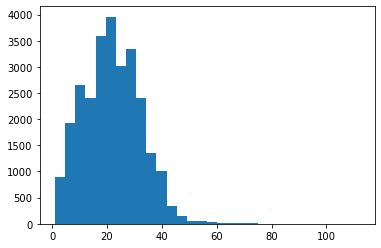

In [208]:
lengths = []
for el in list_of_directions:
    lengths.append(len(el))
plt.hist(lengths, bins = 30) # in 30 seconds there can be no more than 30 bouts!

In [5]:
df

,index,setup_index,arena_index,experiment_repeat,fish_ID,folder_name,fish_genotype,fish_age,stimulus_name,trial,...,radius,estimated_orientation_change_flipped,time,left_bouts,right_bouts,straight_bouts,bout_orientation,bout_orientation_absolute,left_bouts_absolute,right_bouts_absolute
0,0,2,0,0,0,2022-12-15_15-40-15_setup2_arena0,WT,5 dpf,gray,0,...,0.828901,-24.707858,0.978714,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0
1,1,2,0,0,0,2022-12-15_15-40-15_setup2_arena0,WT,5 dpf,gray,0,...,0.810732,-5.445908,2.134261,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0
2,2,2,0,0,0,2022-12-15_15-40-15_setup2_arena0,WT,5 dpf,gray,0,...,0.802130,-36.886872,5.378679,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0
3,3,2,0,0,0,2022-12-15_15-40-15_setup2_arena0,WT,5 dpf,gray,0,...,0.799478,-4.694998,6.578669,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0
4,4,2,0,0,0,2022-12-15_15-40-15_setup2_arena0,WT,5 dpf,gray,0,...,0.785635,-0.539227,8.911983,0.0,0.0,1.0,0.0,-1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842530,842530,1,7,0,106,2022-12-20_16-50-22_setup1_arena7,WT,5 dpf,motion_rightward,7,...,0.898744,-1.854388,45.813743,0.0,0.0,1.0,0.0,-1.0,0.0,1.0
842531,842531,1,7,0,106,2022-12-20_16-50-22_setup1_arena7,WT,5 dpf,motion_rightward,7,...,0.899167,0.572336,46.524848,0.0,0.0,1.0,0.0,1.0,1.0,0.0
842532,842532,1,7,0,106,2022-12-20_16-50-22_setup1_arena7,WT,5 dpf,motion_rightward,7,...,0.899097,1.344777,48.191501,0.0,0.0,1.0,0.0,1.0,1.0,0.0
842533,842533,1,7,0,106,2022-12-20_16-50-22_setup1_arena7,WT,5 dpf,motion_rightward,7,...,0.899143,0.153143,49.48038,0.0,0.0,1.0,0.0,1.0,1.0,0.0


(array([165563.,  63406.,  33452.,  19062.,  11545.,   7306.,   4805.,
          3330.,   2371.,   1755.,   1336.,   1061.,    795.,    650.,
           559.,    430.,    410.,    334.,    279.,    240.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

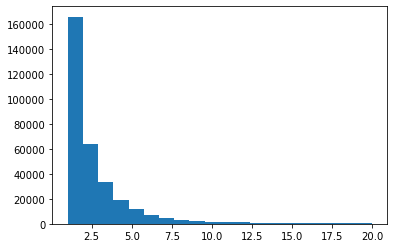

In [27]:
list_of_directions = df['bout_orientation_absolute']
def streak_length(list_of_directions):
    list_of_streaks = [] # i save here the length of the streak, defined as a_streak
    a_streak = 1 # we keep track of each streak length here, and when the streak is done, we append it to the list_of_streaks. streak length is 1 if only one bout was done in that direction
    for element in range(1,len(list_of_directions)): # we start from one bcs we compare with 0th element
        if list_of_directions[element-1]==list_of_directions[element]:
            a_streak += 1
        else:
            list_of_streaks.append(a_streak)
            a_streak = 1
    list_of_streaks.append(a_streak)
    list_of_streaks = [x for x in list_of_streaks if x <= 20]
    return list_of_streaks
plt.hist(streak_length(list_of_directions),bins = 20)

In [143]:
def streak_length_v2(global_list):
    list_of_streaks = [] # i save here the length of the streak, defined as a_streak
    a_streak = 1 # we keep track of each streak length here, and when the streak is done, we append it to the list_of_streaks. streak length is 1 if only one bout was done in that direction
    for list_of_directions in global_list():
        for element in range(1,len(list_of_directions)): # we start from one bcs we compare with 0th element
            if list_of_directions[element-1]==list_of_directions[element]:
                a_streak += 1
            else:
                list_of_streaks.append(a_streak)
                a_streak = 1
        list_of_streaks.append(a_streak)
        a_streak = 1
    list_of_streaks.append((a_streak))
   # list_of_streaks = [x for x in list_of_streaks if x <= 25]
    return list_of_streaks
plt.hist(streak_length(df), bins = 25)

KeyError: 0

In [ ]:
# random and the others:
#[1,1,1,-1,1,1,1,-1,1,-1,1,1,-1] # [3, 1, 3, 1, 1, 1, 2]
#[3,1,3,1,1,1,2,1]

#example 1: rlrlrlrl - only streaks of one, how does cdf look like
#example 2: distribution of rrrlrrrlrrrl so biased on r
#example 3: purely random distribution
>>> my_list = [0]*20 + [1]*20

>>> random.shuffle(my_list)

In [51]:
# lets just make a dataframe for each stimulus and have a cdf for each! a simple one! and compare them
df_gray =df[df['stimulus_name']=='gray']
df_motion_downward =df[df['stimulus_name']=='motion_downward']
df_motion_forward =df[df['stimulus_name']=='motion_forward']
df_motion_leftdown45 = df[df['stimulus_name']=='motion_leftdown45']
df_motion_leftup45 = df[df['stimulus_name']=='motion_leftup45']
df_motion_leftward = df[df['stimulus_name']=='motion_leftward']
df_motion_rightdown45 = df[df['stimulus_name']=='motion_rightdown45']
df_motion_rightup45 = df[df['stimulus_name']=='motion_rightup45']
df_motion_rightward =  df[df['stimulus_name']=='motion_rightward']

In [105]:
import random
l = [0,1,2,3,4,5,6,7,8,9]
random.sample(l,len(l))

[4, 6, 5, 9, 0, 2, 8, 1, 3, 7]

In [52]:
# list_of_directions = data['bout_orientation_absolute'].tolist()
# data_list = streak_length(list_of_directions)
# cdf_pdf(data_list) -->  return cdf,pdf, bins_count[1:]
def plot_cdf(df):
    list_of_directions = df['bout_orientation_absolute'].tolist()
    data_list = streak_length(list_of_directions)
    cdf_data,pdf_data,bins_data = cdf_pdf(data_list)
    # now shuffled:
    list_of_directions_shuffled =random.sample(list_of_directions,len(list_of_directions))
    data_list = streak_length(list_of_directions_shuffled)
    cdf_shuffled,pdf_shuffled,bins_shuffled = cdf_pdf(list_of_directions_shuffled)



In [4]:
def bin_data(label_df, bin_size = 1): # why did i add name_of_data here???
    time_index = label_df['end_time']
    label_df['binned_time'] = time_index - time_index % bin_size + bin_size / 2
    label_df = label_df.reset_index()
    bin_df = label_df.groupby(['fish_ID', 'stimulus_name', 'binned_time']).sum()
    bin_df['total_bouts'] = bin_df.left_bouts + bin_df.right_bouts + bin_df.straight_bouts
    #Analysed part:
    bin_df['preference_index'] = (bin_df.left_bouts - (bin_df.right_bouts + bin_df.straight_bouts))/bin_df.total_bouts
    bin_df['percentage_left'] = (bin_df.left_bouts / bin_df.total_bouts)*100
    bin_df['percentage_right'] = (bin_df.left_bouts / bin_df.total_bouts)*100
    bin_df['percentage_straight'] = (bin_df.left_bouts / bin_df.total_bouts)*100
   # bin_df['left_bouts_absolute'] = (bin_df.left_bouts_absolute / bin_df.total_bouts)*100
   # bin_df['right_bouts_absolute'] = (bin_df.right_bouts_absolute / bin_df.total_bouts)*100
   # bin_df.to_csv(r"C:\Users\ag-bahl\Desktop\dataframes\binned_df"+str(name_of_data)+".csv")
    return bin_df
bin_df = bin_data(df, bin_size = 1)

ValueError: cannot insert level_0, already exists

In [64]:
num_fish = bin_df.index.unique('stimulus_name')

Index(['gray', 'motion_downward', 'motion_forward', 'motion_leftdown45',
       'motion_leftup45', 'motion_leftward', 'motion_rightdown45',
       'motion_rightup45', 'motion_rightward'],
      dtype='object', name='stimulus_name')

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)

def plot_pref(bin_df, pref='preference_index', time_marker=None,plot_together = True):
    num_fish = len(bin_df.index.unique('fish_ID'))
    t_stamp = bin_df.index.unique('binned_time')
    bin_df = bin_df.reset_index()

    mean_df = bin_df.groupby(['stimulus_name', 'binned_time']).mean()
    sem_df = bin_df.groupby(['stimulus_name', 'binned_time']).std() / (num_fish) ** 0.5
    if plot_together == True:
        legend = []
    colors = ['red','purple','cyan','green','orange','blue','pink','brown','violet','red','cyan']
 #   for variable in
    iterate = mean_df.index.unique('stimulus_name')
    for stim in range(len(iterate)):
        if plot_together == True:
            legend.append(str(iterate[stim]))
        else:
            legend = [str(iterate[stim])]
        plot_mean_df = mean_df.xs(iterate[stim], level='stimulus_name')
        plot_sem_df = sem_df.xs(iterate[stim], level='stimulus_name')

        plt.plot(plot_mean_df.preference_index, marker='o', linewidth=1, markersize=2,color = colors[stim])
        plt.fill_between(t_stamp, plot_mean_df.preference_index + plot_sem_df.preference_index,
                         plot_mean_df.preference_index - plot_sem_df.preference_index,
                         alpha=0.25, label='_no_legend_',color = colors[stim])


     #   plt.legend(legend)
     #   plt.show()
    if time_marker != None:
        for t in time_marker:
            plt.axvline(x=t, color='grey', linestyle='--', alpha=0.4, label='_nolegend_')
    plt.plot([0,0],[-1,1], color = 'blue')
    plt.legend(legend)
    plt.title('Sine gratings 8 directions',size = 20)
    plt.xlabel('Time (seconds)', size = 20)
    plt.ylabel('Orientation', size = 20)
    plt.show()

    return plt


In [5]:
plt.rcParams["figure.figsize"] = (12,12)
plot_pref(bin_df, pref='preference_index', time_marker=None)


NameError: name 'plot_pref' is not defined

In [56]:
plot_pref(bin_df, pref='preference_index', time_marker=None)

NameError: name 'bin_df' is not defined

In [ ]:
def plot_pref(bin_df, pref='percentage_left', time_marker=None):
    num_fish = len(bin_df.index.unique('fish_ID'))
    t_stamp = bin_df.index.unique('binned_time')
    bin_df = bin_df.reset_index()

    mean_df = bin_df.groupby(['stimulus_name', 'binned_time']).mean()
    sem_df = bin_df.groupby(['stimulus_name', 'binned_time']).std() / (num_fish) ** 0.5

    legend = []
    for stim in mean_df.index.unique('stimulus_name'):
        legend.append(stim)

        plot_mean_df = mean_df.xs(stim, level='stimulus_name')
        plot_sem_df = sem_df.xs(stim, level='stimulus_name')

        if pref == 'preference_index':
            plt.plot(plot_mean_df.preference_index, marker='o', linewidth=1, markersize=2)
            plt.fill_between(t_stamp, plot_mean_df.preference_index + plot_sem_df.preference_index,
                             plot_mean_df.preference_index - plot_sem_df.preference_index,
                             alpha=0.25, label='_no_legend_')
        elif pref == 'percentage_left':
            plt.plot(plot_mean_df.percentage_left, marker='o', linewidth=1, markersize=2)
            plt.fill_between(t_stamp, plot_mean_df.percentage_left + plot_sem_df.percentage_left,
                             plot_mean_df.percentage_left - plot_sem_df.percentage_left,
                             alpha=0.25, label='_nolegend_')
            plt.axhline(y=50, color='grey', linestyle='--', alpha=0.2, label='_nolegend_')
            plt.ylim(0, 100)
            plt.ylabel('Percentage left')
            plt.xlabel('Time (s)')
    if time_marker != None:
        for t in time_marker:
            plt.axvline(x=t, color='grey', linestyle='--', alpha=0.4, label='_nolegend_')

    plt.legend(legend)
    plt.show()

    return plt

In [ ]:
def plot_orientation(label_df, bins=50):
    c = 0.7
    for stim in label_df.index.unique('stimulus_name'):
        temp_df = label_df.xs(stim, level='stimulus_name')

        plt.hist(temp_df.orientation_change, bins=bins, range=[-180, 180],
                 edgecolor='black', alpha=c - 0.1, )

    plt.show()

    return plt


plot_orientation(label_df, bins=50)